<a href="https://colab.research.google.com/github/Collin-Campbell/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/DS_Sprint_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [63]:
'''T1. Import data file.'''
import pandas as pd
import numpy as np

url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url,
                 parse_dates=['Inspection Date'],
                 index_col='Inspection Date').sort_index()

# Parsed dates, set Inspection Date as the index value, and then sorted them in
# order

print(df.shape)
df.head()

(51916, 17)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2010-01-04,70269,mr.daniel's,mr.daniel's,1899292.0,Restaurant,Risk 1 (High),5645 W BELMONT AVE,CHICAGO,IL,60634.0,License Re-Inspection,NaN,41.938443,-87.768318,"{'longitude': '-87.76831838068422', 'latitude'...",0,NaN
2010-01-04,67732,WOLCOTT'S,TROQUET,1992039.0,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,CHICAGO,IL,60613.0,License Re-Inspection,NaN,41.961606,-87.675967,"{'longitude': '-87.67596676683779', 'latitude'...",0,NaN
2010-01-05,96246,THE LEARNING TREE II,THE LEARNING TREE II,1869843.0,Daycare Above and Under 2 Years,Risk 1 (High),8233 S PULASKI RD,CHICAGO,IL,60652.0,License,NaN,41.742993,-87.721558,"{'longitude': '-87.72155821260196', 'latitude'...",0,NaN
2010-01-05,70273,THE GREAT AMERICAN BAGEL,THE GREAT AMERICAN BAGEL (T3-H10),1879164.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,Canvass,"9. WATER SOURCE: SAFE, HOT & COLD UNDER CITY P...",42.008536,-87.914428,"{'longitude': '-87.91442843927047', 'latitude'...",1,0.0
2010-01-05,67758,SU TAQUERIA EL GALLO BRAVO #4,SU TAQUERIA EL GALLO BRAVO #4,1766968.0,Restaurant,Risk 1 (High),5650 W GRAND AVE,CHICAGO,IL,60639.0,Complaint,19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...,41.919224,-87.767734,"{'longitude': '-87.76773430251839', 'latitude'...",1,0.0


**Task 1 Test**

In [64]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [65]:
'''T2. Identify data leakage column.'''
leaky_col = 'Serious Violations Found'

# 'Serious Violations Found' contains information that would not be available to
#  our model to make predictions


**Task 2 Test**

In [66]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.

'T2 Test'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns.
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [67]:
# Top ten values in Facility Type column
top10_fac_type = df['Facility Type'].value_counts()[:10].index

# At locations where the facility type is NOT in the top 10, 
# replace the facility type with 'Other'
df.loc[~df['Facility Type'].isin(top10_fac_type), 'Facility Type'] = 'Other'

In [68]:
# Top ten values in Inspection Type column
top10_insp_type = df['Inspection Type'].value_counts()[:10].index

# At locations where the inspection type is NOT in the top 10, 
# replace the inspection type with 'Other'
df.loc[~df['Inspection Type'].isin(top10_insp_type), 'Inspection Type'] = 'Other'

In [69]:
df.nunique()

Inspection ID               51916
DBA Name                    17049
AKA Name                    16350
License #                   21421
Facility Type                  11
Risk                            3
Address                     13954
City                           39
State                           1
Zip                            86
Inspection Type                11
Violations                  42164
Latitude                    13410
Longitude                   13410
Location                    13410
Fail                            2
Serious Violations Found        9
dtype: int64

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51916 entries, 2010-01-04 to 2019-03-20
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Inspection ID             51916 non-null  int64  
 1   DBA Name                  51916 non-null  object 
 2   AKA Name                  51293 non-null  object 
 3   License #                 51911 non-null  float64
 4   Facility Type             51916 non-null  object 
 5   Risk                      51904 non-null  object 
 6   Address                   51916 non-null  object 
 7   City                      51863 non-null  object 
 8   State                     51906 non-null  object 
 9   Zip                       51890 non-null  float64
 10  Inspection Type           51916 non-null  object 
 11  Violations                42261 non-null  object 
 12  Latitude                  51718 non-null  float64
 13  Longitude                 51718 non-null  fl

In [71]:
'''T3. Write wrangle function.'''
def wrangle(df):

  # Make a copy
  df = df.copy()

  # Remove leaky column
  df.drop(columns=leaky_col, inplace=True)

  # Drop high cardinality cols
  high_card_cols = [col for col in df.select_dtypes('object').columns
                    if df[col].nunique() > 100]

  df.drop(columns=high_card_cols, inplace=True)

  # Drop cat cols with one category
  one_cat_cols = [col for col in df.select_dtypes('object').columns
                    if df[col].nunique() == 1]

  df.drop(columns=one_cat_cols, inplace=True)

  # Drop num cols that are unique identifiers for each observation
  float_cols = [col for col in df.select_dtypes('float64').columns
                    if df[col].nunique() > 20000]

  df.drop(columns=float_cols, inplace=True)

  int_cols = [col for col in df.select_dtypes('int64').columns
                    if df[col].nunique() > 20000]

  df.drop(columns=int_cols, inplace=True)

  return df


df = wrangle(df)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51916 entries, 2010-01-04 to 2019-03-20
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Facility Type    51916 non-null  object 
 1   Risk             51904 non-null  object 
 2   City             51863 non-null  object 
 3   Zip              51890 non-null  float64
 4   Inspection Type  51916 non-null  object 
 5   Latitude         51718 non-null  float64
 6   Longitude        51718 non-null  float64
 7   Fail             51916 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 3.6+ MB


In [73]:
print(df.shape)
df.head()

(51916, 8)


,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60634.0,License Re-Inspection,41.938443,-87.768318,0
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60613.0,License Re-Inspection,41.961606,-87.675967,0
2010-01-05,Daycare Above and Under 2 Years,Risk 1 (High),CHICAGO,60652.0,License,41.742993,-87.721558,0
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60666.0,Canvass,42.008536,-87.914428,1
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60639.0,Complaint,41.919224,-87.767734,1


**Task 3 Test**

In [74]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [88]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'

# Splitting into target and feature matrix

y = df[target]
X = df.drop(columns=target)

**Task 4 Test**

In [89]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [90]:
'''T5. Split dataset into training and validation sets.'''

# Splitting into training and validation sets

cutoff = '2017-01-01'
mask = df.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

**Task 5 Testing**

In [91]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [92]:
'''T6. Establish baseline accuracy.'''

# Establishing baseline (classification problem, so majority class)

baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [93]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [94]:
'''T7. Build model with bagging predictor.'''
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Building model pipeline

model_bag = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(random_state=42,
                            n_jobs=-1)
      )

model_bag.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Tast 7 Testing**

In [95]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [96]:
'''T8. Build model with boosting predictor.'''
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# Building model pipeline

model_boost = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      XGBClassifier(random_state=42,
                            n_jobs=-1)
      )

model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [97]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [98]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9072847682119205
Validation accuracy: 0.6836158192090396

Boosting Model
Training accuracy: 0.7542974633609869
Validation accuracy: 0.7047279214986619


In [ ]:
# Neither of the two models beat the baseline accuracy score, but the boosting
# model appears to perform better than the bagging model.  It has both a 
# higher validation score and less variance than the bagging model.

**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

In [100]:
'''T9. Plot ROC-curve.'''

from sklearn.metrics import roc_curve

bag = model_bag.fit(X_train, y_train)
boost = model_boost.fit(X_train, y_train)

y_pred_prob1 = bag.predict_proba(X_val)[:,1]
y_pred_prob2 = boost.predict_proba(X_val)[:,1]

fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_prob1)
fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred_prob2)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


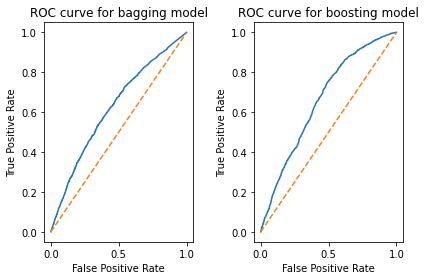

In [111]:
# Plotting the ROC curves
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(fpr1, tpr1)
plt.plot([0,1], ls='--')
plt.title('ROC curve for bagging model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(1, 2, 2)
plt.plot(fpr2, tpr2)
plt.plot([0,1], ls='--')
plt.title('ROC curve for boosting model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()


**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [116]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report


model_cr = classification_report(y_val, model_boost.predict(X_val))

print(model_cr)

              precision    recall  f1-score   support

           0       0.71      0.99      0.83      7092
           1       0.59      0.02      0.04      2997

    accuracy                           0.70     10089
   macro avg       0.65      0.51      0.43     10089
weighted avg       0.67      0.70      0.59     10089



**Task 10 Testing**

In [117]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [128]:
'''Task 11. Create DataFrame of permutation importances.'''

# Determining Permutation Importance

from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(model_boost, X_val, y_val, n_jobs=-1, random_state=42)


# Putting results into DataFrame
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

permutation_importances = pd.DataFrame(data, index=X_val.columns)
permutation_importances.sort_values('importances_mean', ascending=True, inplace=True)

print(permutation_importances.shape)
permutation_importances

(7, 2)


,importances_mean,importances_std
City,0.000000,0.000000
Longitude,0.000971,0.000825
Zip,0.001507,0.000933
Risk,0.001784,0.000273
Latitude,0.001903,0.000544
Facility Type,0.002260,0.000383
Inspection Type,0.002577,0.000825


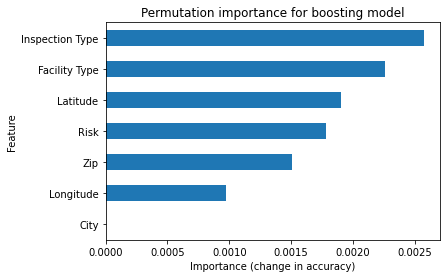

In [129]:
import matplotlib.pyplot as plt

# Making a plot
permutation_importances['importances_mean'].tail(7).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for boosting model');

**Task 11 Testing**

In [130]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

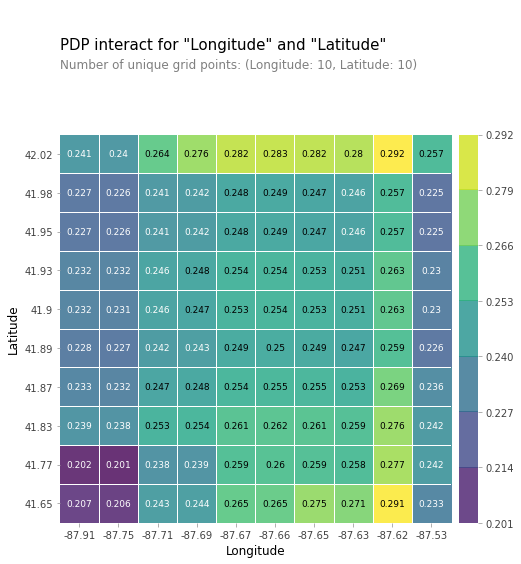

In [132]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''

features = ['Longitude', 'Latitude']

# Plotting PDP interaction plot for Longitude and Latitude

from pdpbox.pdp import pdp_interact, pdp_interact_plot

interact = pdp_interact(
    model=model_boost,
    dataset=X_val.dropna(),
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

What do you think? Is there a relationship between location and failing a food safety inspection?

In [133]:
# Yes, it appears there is an increase in failures of food safety 
# inspections at lower longitudes and lower latitudes.  This leads me
# to believe this general location has higher rates of failure.